# Selective Search 와 R-CNN을 이용한 객체 탐지

## 공통모듈

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense
from keras import Model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os,cv2

import datetime
import time
import pickle
import csv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 이미지와 좌표데이터 압축해제

In [ ]:
!unzip roi-segmentArea.zip
!unzip ElectricityMeter.zip

## 훈련데이터셋을 만드는 클래스

In [7]:
# 전력량계량기의 전력량세그먼트 이미지와 좌표를 이용하여 훈련데이터셋을 만드는 클래스
class TrainDataSet :

    def __init__(self, elect_file_path, coordi_file_path):
        self.elect_file_path = elect_file_path
        self.coordi_file_path = coordi_file_path
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.testdata = None
        self.traindata = None

    # 이미지 크기(w, h)를 (width,h*(500/w))의 비율로 정형화하기
    def resize(self, img, width):
        # 이미지 resize하기
        src_height, src_width = img.shape[:2]

        # 이미지 가로길이가 700이 되도록 설정함
        ratio = 700 / src_width
        src_height, src_width = int(src_height * ratio), int(src_width * ratio)
        # 파라미터 입력 시에는 가로, 세로 순서로 입력
        resized_img = cv2.resize(img, (src_width, src_height))
        return resized_img

    # IoU 계산하는 함수
    def get_iou(self, bb1, bb2):
        assert bb1['x1'] < bb1['x2']
        assert bb1['y1'] < bb1['y2']
        assert bb2['x1'] < bb2['x2']
        assert bb2['y1'] < bb2['y2']

        x_left = max(bb1['x1'], bb2['x1'])
        y_top = max(bb1['y1'], bb2['y1'])
        x_right = min(bb1['x2'], bb2['x2'])
        y_bottom = min(bb1['y2'], bb2['y2'])

        if x_right < x_left or y_bottom < y_top:
            return 0.0

        intersection_area = (x_right - x_left) * (y_bottom - y_top)

        bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
        bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

        iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
        assert iou >= 0.0
        assert iou <= 1.0
        return iou

    # Selective Search Segmentation을 이용하여 IoU 계산하는 함수
    def saveTrainDataSet(self):
        coordi_file_list = os.listdir(self.coordi_file_path)
        
        print("trainDataSet 만들기...")
        print("trainDataSet개수 : ", len(coordi_file_list))
        # 사용할 search segmentation 의 수
        numUseRects = 150
        train_images = []
        train_labels = []
        
        # 모든 좌표파일 개수만큼 순회
        for e, i in enumerate(coordi_file_list):
            try:
                print(e, " 번째 이미지 데이터 생성중 : ", i)
                # 이미지파일명 생성
                filename = i.split(".")[0] + ".jpg"
                # 이미지파일 읽어오기
                image = cv2.imread(os.path.join(self.elect_file_path, filename))
                # 사이즈 줄이기
                image = self.resize(image, 700)
                # 좌표를 저장할 dictionary
                gtvalue = dict()
                # 좌표파일 열기
                f = open(os.path.join(self.coordi_file_path, i), 'r', encoding='utf-8')
                # 파일내용 읽어오기
                rdr = csv.reader(f)
                # 내용 라인 수 만큼 순회(어차피 1줄)
                for line in rdr:
                    x1 = int(line[0])
                    y1 = int(line[1])
                    x2 = int(line[2])
                    y2 = int(line[3])

                    # 좌표저장
                    gtvalue = {"x1": x1, "x2": x2, "y1": y1, "y2": y2}
                ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
                # 초기화
                ss.setBaseImage(image)
                #  SelectiveSearch(저퀄리티 고속)
                ss.switchToSelectiveSearchFast()
                # 이미지파일에 대한 selective search segmentation 생성하여 저장
                ssresults = ss.process()
                # 출력할 이미지생성
                imout = image.copy()
                counter = 0
                falsecounter = 0
                flag = 0
                fflag = 0
                bflag = 0

                # 생성된 search segmentation의 수만큼 순회
                for s, result in enumerate(ssresults):
                    # 150개까지 생성
                    if s < numUseRects and flag == 0:
                        # search segmentation의 왼쪽 상단좌표와 width, height취득
                        x, y, w, h = result

                        # iou 추출
                        iou = self.get_iou(gtvalue, {"x1": x, "x2": x + w, "y1": y, "y2": y + h})
                        # iou 점수가 0.7넘는 search segmentation를 30장까지 저장
                        # 레이블을 1로 설정
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y + h, x:x + w]
                                resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
                                train_images.append(resized)
                                # 레이블 1 저장
                                train_labels.append(1)
                                counter += 1
                        else:
                            fflag = 1
                        # iou 점수가 0.3이하인 search segmentation를 30장까지 저장
                        # 레이블을 0으로 설정
                        if falsecounter < 30:
                            if iou < 0.3:
                                timage = imout[y:y + h, x:x + w]
                                # 입력크기 변경하기
                                resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
                                train_images.append(resized)
                                # 레이블 0 저장
                                train_labels.append(0)
                                falsecounter += 1
                        else:
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
                print(e, " 번째 이미지 데이터 생성완료 : ", i)
            except Exception as e:
                print(e)
                print("error in " + filename)
                continue
        
        # 훈련, 테스트 데이터를 분리
        self.splitTrainTest(train_images, train_labels)

        # 훈련이미지와, 훈련레이블을 파일로 저장
        self.saveTrainDataFile(train_images, train_labels)
        return train_images, train_labels

    # 훈련, 테스트 데이터를 분리하는 함수
    def splitTrainTest(self, train_images, train_labels):
        self.X_new = np.array(train_images)
        self.y_new = np.array(train_labels)


        lenc = MyLabelBinarizer()
        Y = lenc.fit_transform(self.y_new)
        print("test")
        print(len(self.X_new), len(Y))
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X_new, Y, test_size=0.10)
        print("test")
        print(self.X_train.shape, self.X_test.shape, self.y_train.shape, self.y_test.shape)
        
        trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
        self.traindata = trdata.flow(x=self.X_train, y=self.y_train)
        tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
        self.testdata = tsdata.flow(x=self.X_test, y=self.y_test)
        

    def saveTrainDataFile(self, train_images, train_labels):
        ## Save pickle
        with open(DATAPATH + "train_data/train_images.pickle","wb") as fw:
        # with open("train_images.pickle","wb") as fw:
            pickle.dump(train_images, fw)
        ## Save pickle
        with open(DATAPATH + "train_data/train_labels.pickle","wb") as fw:
        # with open("train_labels.pickle","wb") as fw:
            pickle.dump(train_labels, fw)

        with open("train_labels.csv", 'w', newline='') as out:
            csv.writer(out).writerow(train_labels)

        with open("train_labels.txt", 'w', newline='') as out:
            csv.writer(out).writerow(train_labels)

## 모델 생성-훈련-검증 클래스

In [8]:
class Vgg_Model:
    
    def __init__(self):
        self.model = self.__createModel()
        self.hist = None

    # 모델생성하는 비공개 메소드
    def __createModel(self):
        print("모델 생성중...")
        vggmodel = VGG16(weights='imagenet', include_top=True)
        # 모델 구조확인
        print(vggmodel.summary())

        for layers in (vggmodel.layers)[:15]:
            print(layers)
            layers.trainable = False
        X = vggmodel.layers[-2].output
        predictions = Dense(2, activation="softmax")(X)
        self.model = Model(inputs=vggmodel.input, outputs=predictions)

        opt = keras.optimizers.Adam(learning_rate=0.01)
        self.model.compile(loss=keras.losses.categorical_crossentropy, 
                            optimizer=opt,
                            metrics=["accuracy"])
        print("최종 모델 생성")
        
        print(self.model.summary())
        return self.model
        
    # 모델훈련 메소드
    def vggModelTraining(self, traindata, testdata):

        checkpoint = ModelCheckpoint(DATAPATH + "ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True,
                                     save_weights_only=False, mode='auto', save_freq='epoch')
        early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
        # 모델 훈련 시작
        print("모델 훈련 시작 : ")
        start = time.time()
        self.hist = self.model.fit(traindata , steps_per_epoch=10, epochs=1000, validation_data=testdata, validation_steps=2,
                               callbacks=[checkpoint, early])
        end = time.time()
        print("모델 훈련 종료 : ", end)
        runtime = end - start
        
        # 코드 수행 시간을 [시:분:초, 나머지]로 표현
        runTime_pretty = datetime.timedelta(seconds=runtime)
        print('모델 훈련하는데 걸린 시간 :', runTime_pretty)

    # 모델평가,저장,차트저장 메소드
    def vggModelEvaluate(self, X_test, y_test) :

        # 모델 평가
        self.model.evaluate(X_test, y_test, verbose=2)
        # tflite모델 저장
        self.convertTensorFlowLite()
        # loss차트와 acc차트 저장
        self.saveLossAccChart()
    
    # TensorFlowLite 모델로 변환
    def convertTensorFlowLite(self):
        converter = tf.lite.TFLiteConverter.from_keras_model(self.model)
        tflite_model = converter.convert()

        with open(DATAPATH + 'keras_model_ob_detection.tflite', 'wb') as f:
            f.write(tflite_model)

    # loss차트와 acc차트를 저장하는 메소드
    def saveLossAccChart(self):
        history_dict = self.hist.history
        loss = history_dict['loss']
        val_loss = history_dict['val_loss']
        plt.plot(loss)
        plt.plot(val_loss)
        plt.title("model loss")
        plt.xlabel('Epochs')
        plt.ylabel('loss')
        plt.legend(["Loss","Validation Loss"])
        plt.show()
        plt.savefig(DATAPATH + 'train_result/chart loss.png')

        acc = history_dict['accuracy']
        val_acc = history_dict['val_accuracy']
        epochs = range(1, len(acc) + 1)
        plt.plot(acc)
        plt.plot(val_acc)
        plt.title("model accuracy")
        plt.xlabel('Epochs')
        plt.ylabel('accuracy')
        plt.legend(["Acc","Validation Acc"])
        plt.show()
        plt.savefig(DATAPATH + 'train_result/chart accuracy.png')



## 레이블 이진화클래스

In [4]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)


# 훈련데이터셋~모델 검증까지 한번에 실행

In [ ]:
# 이미지폴더
ELECT_PATH = "ElectricityMeter"
# 좌표정보 폴더
COORDI_PATH = "roi"

# 데이터저장 패스
DATAPATH = "/content/drive/MyDrive/Colab Notebooks/k-digital/00_lpinProject/data/"

# 전력량계량기의 전력량세그먼트 이미지와 좌표를 이용하여 훈련데이터셋을 만드는 클래스
trainDataSet = TrainDataSet(ELECT_PATH, COORDI_PATH)
train_images, train_labels = trainDataSet.saveTrainDataSet()


# 모델 생성
vgg_model = Vgg_Model()
# 모델 훈련
vgg_model.vggModelTraining(trainDataSet.traindata, trainDataSet.testdata)
# 모델 평가
vgg_model.vggModelEvaluate(trainDataSet.X_test, trainDataSet.y_test)

trainDataSet 만들기...
trainDataSet개수 :  789
0  번째 이미지 데이터 생성중 :  01232010131_P197
0  번째 이미지 데이터 생성완료 :  01232010131_P197
1  번째 이미지 데이터 생성중 :  01232004509_P1165
1  번째 이미지 데이터 생성완료 :  01232004509_P1165
2  번째 이미지 데이터 생성중 :  01232007863_P1139
2  번째 이미지 데이터 생성완료 :  01232007863_P1139
3  번째 이미지 데이터 생성중 :  01232007559_P154
3  번째 이미지 데이터 생성완료 :  01232007559_P154
4  번째 이미지 데이터 생성중 :  01232004639_P1138
4  번째 이미지 데이터 생성완료 :  01232004639_P1138
5  번째 이미지 데이터 생성중 :  01232007461_P163
5  번째 이미지 데이터 생성완료 :  01232007461_P163
6  번째 이미지 데이터 생성중 :  01232009689_P1105
6  번째 이미지 데이터 생성완료 :  01232009689_P1105
7  번째 이미지 데이터 생성중 :  01232005365_P1115
7  번째 이미지 데이터 생성완료 :  01232005365_P1115
8  번째 이미지 데이터 생성중 :  01232009716_P123
8  번째 이미지 데이터 생성완료 :  01232009716_P123
9  번째 이미지 데이터 생성중 :  01232005741_P150
9  번째 이미지 데이터 생성완료 :  01232005741_P150
10  번째 이미지 데이터 생성중 :  01232007295_P143
10  번째 이미지 데이터 생성완료 :  01232007295_P143
11  번째 이미지 데이터 생성중 :  01232005274_P125
11  번째 이미지 데이터 생성완료 :  01232005274_P125
12  번째 이미지 데이터 생성중 :

# 검증데이터의 예측 결과확인

In [ ]:
X_test = trainDataSet.X_test
model=vgg_model.model

im = X_test[14]
plt.imshow(im)
img = np.expand_dims(im, axis=0)

out= model.predict(img)
if out[0][0] > out[0][1]:
    print("object")
else:
    print("not object")

# 저장된 훈련데이터파일 불러오고 훈련데이터와 검증데이터 분리하기

In [5]:
DATAPATH = "/content/drive/MyDrive/Colab Notebooks/k-digital/00_lpinProject/data/"

train_image_path = DATAPATH + "train_data/train_images.pickle"
train_label_path = DATAPATH + "train_data/train_labels.pickle"

with open(train_image_path,"rb") as fw:
    train_image = pickle.load(fw)
    print(train_image)
with open(train_label_path,"rb") as fw:
    train_label = pickle.load(fw)
print(train_image)
X_new = np.array(train_image)
y_new = np.array(train_label)

lenc = MyLabelBinarizer()
Y = lenc.fit_transform(y_new)

print("test")
print(len(X_new), len(Y))
X_train, X_test , y_train, y_test = train_test_split(X_new, Y, test_size=0.10)
print("test")
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



test
24346 24346
test
(21911, 224, 224, 3) (2435, 224, 224, 3) (21911, 2) (2435, 2)


# 모델 재생성 훈련 평가

test
24346 24346
test
(21911, 224, 224, 3) (2435, 224, 224, 3) (21911, 2) (2435, 2)
모델 생성중...
553476096/553467096 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (No

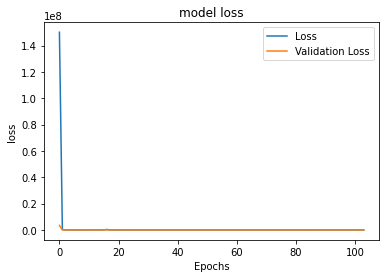

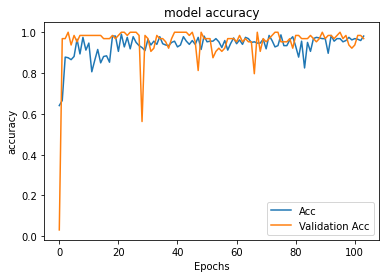

<Figure size 432x288 with 0 Axes>

In [10]:
# 모델 생성
vgg_model = Vgg_Model()
# 모델 훈련
vgg_model.vggModelTraining(traindata, testdata)
# 모델 평가
vgg_model.vggModelEvaluate(X_test, y_test)

# loss와 accuracy 출력

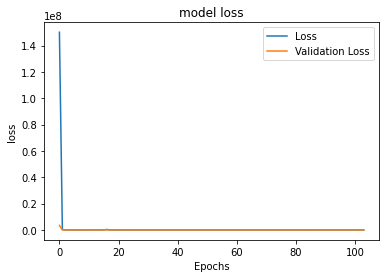

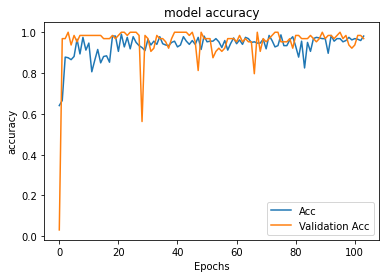

In [17]:
hist2 = vgg_model.hist


history_dict = hist2.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title("model loss")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(["Loss","Validation Loss"])
plt.show()
# plt.savefig(DATAPATH + 'train_result/chart loss.png')

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title("model accuracy")
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(["Acc","Validation Acc"])
plt.show()
# plt.savefig(DATAPATH + 'train_result/chart accuracy.png')


In [16]:
DATAPATH = "/content/drive/MyDrive/Colab Notebooks/k-digital/00_lpinProject/data/"
vgg_model = keras.models.load_model(DATAPATH + "ieeercnn_vgg16_1.h5")
opt = keras.optimizers.Adam(learning_rate=0.01)

vgg_model.compile(loss=keras.losses.categorical_crossentropy, 
                            optimizer=opt,
                            metrics=["accuracy"])
# model evaluation
score = vgg_model.evaluate(X_test,y_test,verbose=0)

print("%s : %.2f%%" % (vgg_model.metrics_names[1], score[1]*100))

accuracy : 97.74%


In [15]:
for im in X_test:
    img = np.expand_dims(im, axis=0)
    out= vgg_model.predict(img)
    if out[0][0] > out[0][1]:
        print("object")
        plt.imshow(im)

In [ ]:
hist2 = vgg_model.hist


history_dict = hist2.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title("model loss")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(["Loss","Validation Loss"])
plt.show()
# plt.savefig(DATAPATH + 'train_result/chart loss.png')

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title("model accuracy")
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(["Acc","Validation Acc"])
plt.show()
# plt.savefig(DATAPATH + 'train_result/chart accuracy.png')


In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
z=0
path = DATAPATH + "image_sample"
for e,i in enumerate(os.listdir(path)):
    z += 1
    img = cv2.imread(os.path.join(path,i))
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = img.copy()
    for e,result in enumerate(ssresults):
        if e < 150:
            x,y,w,h = result
            timage = imout[y:y+h,x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            out= model.predict(img)
            if out[0][0] > 0.65:
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
    plt.figure()
    plt.imshow(imout)